In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import json
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split

from tqdm import tqdm

##########################
### SETTINGS
##########################
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Others
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

PATH = './data/'
IMAGE_PATH = PATH+'images/'
TRAIN_PATH = IMAGE_PATH+'train/'
TEST_PATH  = IMAGE_PATH+'test/'
SAVE_PATH  = PATH+"vgg16.pth"
# Set seed for reproducibility
torch.manual_seed(RANDOM_SEED)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
])

with open(PATH+'label_v2.json') as file:
    data = json.load(file)
dataframe = pd.DataFrame(data['train'],columns=['filename','labels'])
test_dataframe = pd.DataFrame(data['test'],columns=['filename','labels'])

classes = pd.unique(dataframe.labels)
for idx, row in dataframe.iterrows():
    dataframe['labels'][idx] = np.where(classes == row['labels'])[0][0]

train_dataframe, validation_dataframe = train_test_split(dataframe, test_size=0.2)

In [11]:
print(classes)

[ 9 20  7  2  6  1 14 11 16  5 15  8 18 17]


In [10]:
train_dataframe['labels'].value_counts()

1     2043
4     1029
0     1026
5     1024
6      533
7      525
11     523
10     521
9      517
2      514
3      514
13     495
8      490
12     486
Name: labels, dtype: int64

In [4]:
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader

class FarmDataset(Dataset):
    def __init__(self, data, images_dir, transform=None):
        if type(data) is pd.DataFrame:
            self.dataframe = data
        else : 
            self.dataframe = pd.DataFrame(data,columns=['filename','labels'])
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.images_dir,
                                self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]
        filename = self.dataframe.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return filename, image, label


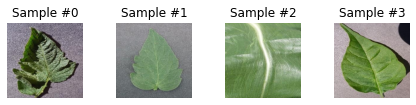

In [5]:
import matplotlib.pyplot as plt

train_dataset = FarmDataset(data=dataframe,images_dir=TRAIN_PATH)

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[1])
    if i==3:
        plt.show()
        break

In [6]:
torch.cuda.empty_cache()

In [7]:
from torch import nn
import torch.nn.functional as F

class vgg19(nn.Module):
    def __init__(self, D_out):
        super().__init__()        
        self.conv = nn.Sequential(
            #3 224 128
            nn.Conv2d(3, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #64 112 64
            nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #128 56 32
            nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #256 28 16
            nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #512 14 8
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
        #512 7 4

        self.avg_pool = nn.AvgPool2d(7)
        #512 1 1
        self.classifier = nn.Linear(512, D_out)

    def forward(self, x):
        #print(x.size())
        features = self.conv(x)
        #print(features.size())
        x = self.avg_pool(features)
        #print(avg_pool.size())
        x = x.view(features.size(0), -1)
        #print(flatten.size())
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

In [8]:
from torchvision import models

def classifier(D_out):
  resnet18 = models.resnet18()
  num_ftrs = resnet18.fc.in_features 
  resnet18.fc = nn.Linear(num_ftrs, D_out) 

  return resnet18

In [9]:
model = classifier(14)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
train_dataset = FarmDataset(data=train_dataframe,images_dir=TRAIN_PATH,transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataset = FarmDataset(data=validation_dataframe,images_dir=TRAIN_PATH,transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

epochs = 2
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0    
    val_running_loss = 0.0
    val_running_corrects = 0.0

    if(e>0):
        model = classifier(14)
        model.load_state_dict(torch.load(SAVE_PATH))
        model.to(DEVICE)

    for filenames, images, labels in tqdm(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        outputs = outputs.to(DEVICE)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += (preds == labels).sum().item()
    else:
        with torch.no_grad():
            for val_filename, val_images, val_labels in tqdm(validation_loader):
                val_images = val_images.to(DEVICE)
                val_labels = val_labels.to(DEVICE)
                val_outputs = model(val_images)
                val_outputs = val_outputs.to(DEVICE)
                val_loss = criterion(val_outputs, val_labels)
        
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += (val_preds == val_labels).sum().item()

    torch.save(model.state_dict(), SAVE_PATH)
    
    epoch_loss = running_loss/len(train_dataset)
    epoch_acc = running_corrects/ len(train_dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_dataset)
    val_epoch_acc = val_running_corrects/ len(validation_dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch :', (e+1))
    print('training loss: {:.4f}, training acc {:.4f} '.format(epoch_loss, epoch_acc))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc))

100%|██████████| 320/320 [00:15<00:00, 20.94it/s]
epoch : 1
training loss: 0.3146, training acc 0.1829 
validation loss: 0.3163, validation acc 0.1703 
100%|██████████| 320/320 [00:15<00:00, 20.72it/s]
epoch : 2
training loss: 0.3145, training acc 0.1811 
validation loss: 0.3163, validation acc 0.1777 


In [16]:
len(train_dataset)

10240

In [15]:
model = classifier(14)
model.load_state_dict(torch.load(SAVE_PATH))
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
torch.cuda.empty_cache()

SAVE_PATH=PATH+"vgg16.pth"
test_dataset = FarmDataset(data=test_dataframe,images_dir=TEST_PATH,transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

for filenames, images, labels in tqdm(test_loader):
    images = images.to(DEVICE)
    outputs = model(images)
    outputs.to(DEVICE)
    _, preds = torch.max(outputs, 1)
    for idx, filename in enumerate(filenames):
        test_dataframe.loc[
            test_dataframe['filename'] == filename,'preds'
            ] = preds[idx].item()


100%|██████████| 800/800 [00:33<00:00, 24.14it/s]


In [13]:
outs = {'test':[]}
outs_dataframe = test_dataframe[['filename','preds']]
outs_dataframe['preds'] = outs_dataframe['preds'].map(lambda x: classes[int(x)])
outs_list = outs_dataframe.values.tolist()
outs['test']=outs_list

print(outs)
#with open(PATH+'preds.json', 'w') as json_file:
#  json.dump(outs, json_file)

{'test': [['4_11_666.jpg', 20], ['13_20_611.jpg', 20], ['4_7_911.jpg', 20], ['3_20_735.jpg', 20], ['13_6_875.jpg', 20], ['13_9_214.jpg', 20], ['13_6_326.jpg', 20], ['4_2_1105.jpg', 20], ['13_20_1556.jpg', 20], ['5_8_4029.jpg', 20], ['13_17_390.jpg', 20], ['13_17_770.jpg', 20], ['11_14_284.jpg', 20], ['4_2_577.jpg', 20], ['10_20_2528.jpg', 20], ['4_2_198.jpg', 20], ['3_5_545.jpg', 20], ['11_14_1002.jpg', 20], ['5_8_3446.jpg', 20], ['4_7_40.jpg', 20], ['5_8_2477.jpg', 20], ['8_6_856.jpg', 20], ['4_7_944.jpg', 20], ['3_5_556.jpg', 20], ['3_20_603.jpg', 20], ['8_6_813.jpg', 20], ['13_20_1248.jpg', 20], ['3_5_110.jpg', 20], ['8_9_128.jpg', 20], ['10_20_2209.jpg', 20], ['8_6_475.jpg', 20], ['4_7_925.jpg', 20], ['7_20_1087.jpg', 20], ['13_6_807.jpg', 20], ['4_7_115.jpg', 20], ['3_5_555.jpg', 20], ['8_9_511.jpg', 20], ['11_14_1797.jpg', 20], ['4_11_692.jpg', 20], ['13_1_373.jpg', 20], ['8_9_730.jpg', 20], ['13_18_4446.jpg', 20], ['13_6_729.jpg', 20], ['13_9_703.jpg', 20], ['7_1_520.jpg', 20], 

In [14]:
import gc

objects = gc.get_objects()
tensors = [obj for obj in objects if torch.is_tensor(obj)]
cuda_tensors = [t for t in tensors if t.is_cuda]
for t in cuda_tensors:
    data_ptr = t.storage().data_ptr()
    e_type = type(t).__name__
    print(data_ptr, e_type, t.shape)

30119297024 Parameter torch.Size([64, 3, 7, 7])
30119334912 Parameter torch.Size([64])
30119335424 Parameter torch.Size([64])
30119337472 Parameter torch.Size([64, 64, 3, 3])
30119484928 Parameter torch.Size([64])
30119485440 Parameter torch.Size([64])
30119487488 Parameter torch.Size([64, 64, 3, 3])
30119634944 Parameter torch.Size([64])
30119635456 Parameter torch.Size([64])
30119637504 Parameter torch.Size([64, 64, 3, 3])
30119784960 Parameter torch.Size([64])
30119785472 Parameter torch.Size([64])
30119787520 Parameter torch.Size([64, 64, 3, 3])
30119934976 Parameter torch.Size([64])
30119935488 Parameter torch.Size([64])
30119937536 Parameter torch.Size([128, 64, 3, 3])
30120232448 Parameter torch.Size([128])
30120232960 Parameter torch.Size([128])
30120235008 Parameter torch.Size([128, 128, 3, 3])
30120824832 Parameter torch.Size([128])
30120825344 Parameter torch.Size([128])
30087839744 Parameter torch.Size([128, 128, 3, 3])
30120862720 Parameter torch.Size([128])
30120863232 Pa